In [1]:
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class TimeSeriesData():
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        
        #grab a random starting point for each data
        rand_start = np.random.rand(batch_size, 1)
        
        #convert to be on time series  (ts: time series) the starting point can be anywhere. in this way we make them in a way that locate on the time series for sure.
        ts_start = rand_start * (self.xmax - self.xmin - (steps* self.resolution))
        
        #create batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
        
        #create y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        #formatting for the rnn
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)
        

In [5]:
ts_data = TimeSeriesData(250,0,10)

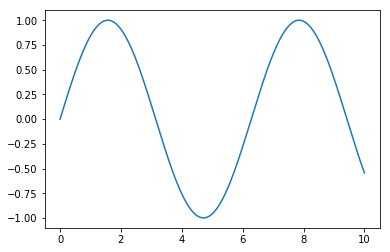

In [6]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [7]:
num_time_steps = 30

In [8]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps, True)

In [9]:
ts.shape  # flattened it to have 1d array instead of 2d

(1, 31)

In [10]:
ts.flatten()

array([1.06182376, 1.10182376, 1.14182376, 1.18182376, 1.22182376,
       1.26182376, 1.30182376, 1.34182376, 1.38182376, 1.42182376,
       1.46182376, 1.50182376, 1.54182376, 1.58182376, 1.62182376,
       1.66182376, 1.70182376, 1.74182376, 1.78182376, 1.82182376,
       1.86182376, 1.90182376, 1.94182376, 1.98182376, 2.02182376,
       2.06182376, 2.10182376, 2.14182376, 2.18182376, 2.22182376,
       2.26182376])

In [11]:
ts.flatten().shape

(31,)

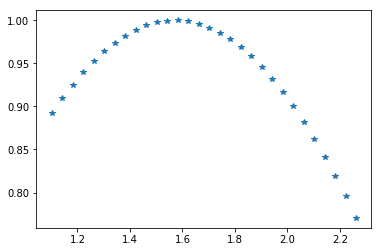

In [12]:
plt.plot(ts.flatten()[1:], y2.flatten(),'*')

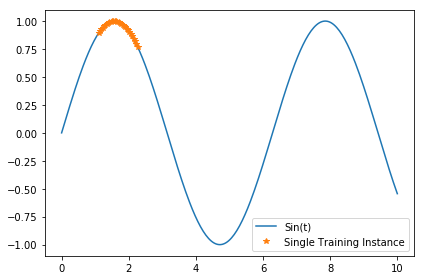

In [13]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(),'*', label='Single Training Instance')

plt.legend()
plt.tight_layout()

In [14]:
train_inst = np.linspace(5, 5+ts_data.resolution*(num_time_steps+1), num_time_steps+1)

In [15]:
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

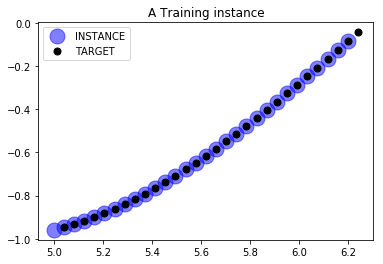

In [16]:
plt.title('A Training instance')

plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='INSTANCE')

plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]), 'ko', markersize=7, label='TARGET')

plt.legend()

## Creating the Model

#### Constants

In [39]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 2000
# Size of the batch of data
batch_size = 1

#### Placeholders

In [42]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

#### RNN cell layer

In [43]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

In [44]:
# outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# #MSE
# loss = tf.reduce_min(tf.square(outputs-y)) 

# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# train = optimizer.minimize(loss)

# init = tf.global_variables_initializer()

# saver = tf.train.Saver()

#### Dynamic RNN Cell

In [47]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

#### Loss Function and Optimizer

In [48]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

#### Init Variables

In [49]:
init = tf.global_variables_initializer()

## Session

In [51]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, 'c:/Users/mojiway/Desktop/rnn_time_series_model_moji_code_along')

0 	MSE: 0.3071788
100 	MSE: 0.41817915
200 	MSE: 0.0025725134
300 	MSE: 0.009507181
400 	MSE: 0.028702041
500 	MSE: 0.0070559997
600 	MSE: 0.039387498
700 	MSE: 0.0029312957
800 	MSE: 0.0029111744
900 	MSE: 0.007219194
1000 	MSE: 0.001419908
1100 	MSE: 0.0136831235
1200 	MSE: 0.0055138096
1300 	MSE: 0.018289391
1400 	MSE: 0.0097729135
1500 	MSE: 0.018165505
1600 	MSE: 0.0035582113
1700 	MSE: 0.0009908467
1800 	MSE: 0.016009627
1900 	MSE: 0.010834785


### Predicting a time series t+1

In [52]:
 with tf.Session() as sess:                          
    saver.restore(sess, 'c:/Users/mojiway/Desktop/rnn_time_series_model_moji_code_along')   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})   

INFO:tensorflow:Restoring parameters from c:/Users/mojiway/Desktop/rnn_time_series_model_moji_code_along


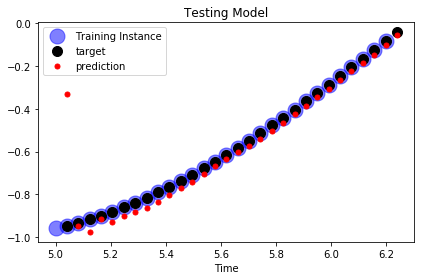

In [54]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

# Generating New Sequences
** Note: Can give wacky results sometimes, like exponential growth**

In [55]:
with tf.Session() as sess:
    saver.restore(sess, 'c:/Users/mojiway/Desktop/rnn_time_series_model_moji_code_along')

    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from c:/Users/mojiway/Desktop/rnn_time_series_model_moji_code_along


Text(0, 0.5, 'Value')

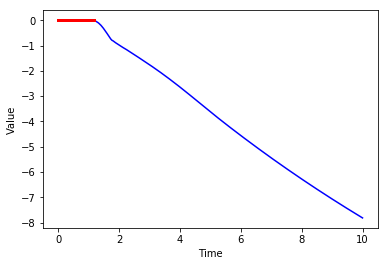

In [56]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [57]:
with tf.Session() as sess:
    saver.restore(sess, 'c:/Users/mojiway/Desktop/rnn_time_series_model_moji_code_along')

    # SEED WITH Training Instance
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(training_instance) -num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from c:/Users/mojiway/Desktop/rnn_time_series_model_moji_code_along


Text(0.5, 0, 'Time')

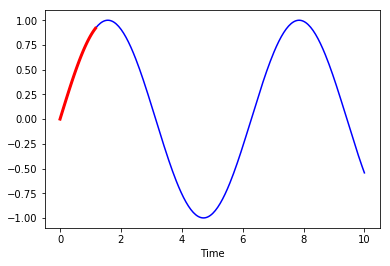

In [58]:
plt.plot(ts_data.x_data, ts_data.y_true, "b-")
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps], "r-", linewidth=3)
plt.xlabel("Time")